# 第七週：文件分類

本周課程為「文件分類」，主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用決策樹、logistic regression等方式訓練模型，以分辨不同的文件。本篇 Jupyter Notebook 將展示「中文」的文件分類，使用聯合新聞網的四個版別文章做示範進行分類器訓練和評估，最後在使用東森新聞的文章進行預測。

## 分析目標
+ 資料內容：
    + 資料來源：聯合新聞網
    + 版別：股市、運動、兩岸、全球

* 分析主題：將聯合新聞網四個版別的文章合起來，訓練模型能預測新聞版別，再用分類模型進行文件的版別分類。

* 以下為教學目標：
    1. 如何將以數字向量代表一篇文章？
        * `CountVectorizer`
        * `TfidfVectorizer`
    2. 基本的分類模型流程，包含以下三步驟：
        * 前處理 (preprocess)
        * 建模 (train model)
        * 評估與預測 (evaluation and predict)
    3. Cross Validation說明
    4. 不同分類器的效果
    5. 可解釋的可視化模型結果
    6. 預測其他家新聞文章的版別

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- **sklearn**: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具

In [1]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

設定中文字體

In [2]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

## 2. 文字前處理
`udn_news_202402.csv`裡面包含了要分析的 udn 新聞資料。
- 版別：股市、全球、運動、兩岸
- 時間範圍：2024/02/01 ~ 2024/02/29
- 工作流程平台搜尋/排除關鍵字：無

首先我們先看文集的基本資料，並做文集前處理。

In [3]:
udn = pd.read_csv("raw_data/udn_news_202402.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,中職／非樹倒猢猻散而是桃李滿天下 戰力外溢彰顯樂天深度,2024-02-01 07:00:00,運動,https://udn.com/news/story/122629/7746474,由於過去幾年在季後的休賽期間總是在人員調動有令人吃驚的動作，因此富邦被戲稱為季後賽王者，沒想...,UDN
1,2,中職／2023驚奇一年 味全龍「紅色大砲」劉基鴻轟出神劇本,2024-02-05 12:00:00,運動,https://udn.com/news/story/122629/7748599,【撰文・鍾亞芳】2021年就曾因骨裂影響出賽，2022季末遭觸身球擊中手腕造成骨裂傷勢，賽季...,UDN
2,3,中職／花店老闆上工 前中信兄弟「轉運手」官大元展開第2人生,2024-02-15 12:00:00,運動,https://udn.com/news/story/122629/7748779,【撰文・鍾亞芳】生涯中大半時間都在思索褪下球員身分後出路，直到2019年收回出租房屋，整理、...,UDN


In [4]:
# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 6531
date range: ('2024-02-01 00:08:00', '2024-02-29 23:57:00')
category: 
artCatagory
股市    1961
兩岸    1670
全球    1614
運動    1286
Name: count, dtype: int64


+ 2.1 斷句
+ 2.2 斷詞（刪掉次數太少的、標點符號、停用字）

### 2.1 清理

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [5]:
# 過濾 nan 的資料
udn = udn.dropna(subset=['artTitle'])
udn = udn.dropna(subset=['artContent'])
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,中職非樹倒猢猻散而是桃李滿天下戰力外溢彰顯樂天深度,2024-02-01 07:00:00,運動,https://udn.com/news/story/122629/7746474,由於過去幾年在季後的休賽期間總是在人員調動有令人吃驚的動作因此富邦被戲稱為季後賽王者沒想到這...,UDN
1,2,中職驚奇一年味全龍紅色大砲劉基鴻轟出神劇本,2024-02-05 12:00:00,運動,https://udn.com/news/story/122629/7748599,撰文鍾亞芳年就曾因骨裂影響出賽季末遭觸身球擊中手腕造成骨裂傷勢賽季提前報銷球隊首度闖進季後挑...,UDN
2,3,中職花店老闆上工前中信兄弟轉運手官大元展開第人生,2024-02-15 12:00:00,運動,https://udn.com/news/story/122629/7748779,撰文鍾亞芳生涯中大半時間都在思索褪下球員身分後出路直到年收回出租房屋整理規畫後老婆對藝術有獨...,UDN


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。

In [6]:
# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,artCatagory
0,中職非樹倒猢猻散而是桃李滿天下戰力外溢彰顯樂天深度由於過去幾年在季後的休賽期間總是在人員調動...,https://udn.com/news/story/122629/7746474,運動
1,中職驚奇一年味全龍紅色大砲劉基鴻轟出神劇本撰文鍾亞芳年就曾因骨裂影響出賽季末遭觸身球擊中手腕...,https://udn.com/news/story/122629/7748599,運動
2,中職花店老闆上工前中信兄弟轉運手官大元展開第人生撰文鍾亞芳生涯中大半時間都在思索褪下球員身分...,https://udn.com/news/story/122629/7748779,運動
3,中職冬盟展現打擊天賦統一獅何恆佑潛力股衝刺一軍撰文鄧心瑜何恆佑是教練團公認訓練認真態度積極選...,https://udn.com/news/story/122629/7748904,運動
4,尼克無懼逆境加速向前衝攻防都進入精英級別紐約尼克最近八連勝勝敗站上東區第三尼克進攻效率第六防...,https://udn.com/news/story/122629/7749189,運動


In [7]:
# 看看有幾篇文章
print(f"total docs: {udn.shape[0]}")


total docs: 6531


### 2.2 斷詞

In [8]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [9]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [10]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

Building prefix dict from /Users/chialin/Documents/SMA助教/SMA_2024S/week7/dict/dict.txt.big ...
Loading model from cache /var/folders/jq/v_01fvx14g7g47h62d_98nl00000gn/T/jieba.u70b620e812ca3a378c250c39883cf040.cache
Loading model cost 0.712 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,words
0,中職非樹倒猢猻散而是桃李滿天下戰力外溢彰顯樂天深度由於過去幾年在季後的休賽期間總是在人員調動...,https://udn.com/news/story/122629/7746474,運動,中職 樹倒猢猻散 桃李滿天下 戰力 外溢 彰顯 樂天 深度 過去 幾年 季後的 休賽 期間 ...
1,中職驚奇一年味全龍紅色大砲劉基鴻轟出神劇本撰文鍾亞芳年就曾因骨裂影響出賽季末遭觸身球擊中手腕...,https://udn.com/news/story/122629/7748599,運動,中職 驚奇 一年 味全 紅色 劉基 出神 劇本 撰文 亞芳 因骨裂 影響 賽季 遭觸 身球 ...
2,中職花店老闆上工前中信兄弟轉運手官大元展開第人生撰文鍾亞芳生涯中大半時間都在思索褪下球員身分...,https://udn.com/news/story/122629/7748779,運動,中職 店老闆 上工 中信 兄弟 轉運 手官 大元 展開 人生 撰文 亞芳 生涯 大半 時間 ...
3,中職冬盟展現打擊天賦統一獅何恆佑潛力股衝刺一軍撰文鄧心瑜何恆佑是教練團公認訓練認真態度積極選...,https://udn.com/news/story/122629/7748904,運動,中職 冬盟 展現 打擊 天賦 統一 獅何 恆佑 潛力股 衝刺 撰文 鄧心 何恆佑 教練 公認...
4,尼克無懼逆境加速向前衝攻防都進入精英級別紐約尼克最近八連勝勝敗站上東區第三尼克進攻效率第六防...,https://udn.com/news/story/122629/7749189,運動,尼克 無懼 逆境 加速 向前 攻防 進入 精英 級別 紐約 尼克 最近 連勝 勝敗 站上 東...


### 2.3 資料集基本檢視

檢視資料內容

In [11]:
print(f"total posts: {len(udn['artUrl'].unique())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")


total posts: 6531
category: 
artCatagory
股市    1961
兩岸    1670
全球    1614
運動    1286
Name: count, dtype: int64


## 3. 分類模型的訓練流程
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。

In [12]:
data = udn
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

2139    日本 利用 官股 銀行 億美元 強化 晶片 電池 供應鏈 日經 新聞報導 官股 背景 日本 ...
1916    一年 穿次 衣服 一次 英女 聲稱 羊毛 結構 特殊 多久 一次 衣服 近日 外媒 報導 英...
258     大谷 翔平 道奇 首戰 連線 感覺 保護 道奇 日籍 二刀 球星 大谷 翔平 今天 春訓 首...
2803    華裔 作家 李翊云 二度 喪子 優等生 普林斯頓大學 車禍 身亡 普林斯頓大學 該校 官網 ...
2089    華爾街 股市 漲勢 激勵 亞洲 多地 股市 漲多 跌少 貨幣政策 緊縮 中國 採取 措施 支...
Name: words, dtype: object
2139    全球
1916    全球
258     運動
2803    全球
2089    全球
Name: artCatagory, dtype: object


In [13]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
股市    30.026030
兩岸    25.570357
全球    24.712908
運動    19.690706
Name: proportion, dtype: float64

train percentage :
artCatagory
股市    29.424634
全球    25.443010
兩岸    25.202363
運動    19.929993
Name: proportion, dtype: float64

test percentage :
artCatagory
股市    31.428571
兩岸    26.428571
全球    23.010204
運動    19.132653
Name: proportion, dtype: float64


### 3.2 將文章轉為 DTM

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字

### 3.3 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [14]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [15]:
X_train.head()

2139    日本 利用 官股 銀行 億美元 強化 晶片 電池 供應鏈 日經 新聞報導 官股 背景 日本 ...
1916    一年 穿次 衣服 一次 英女 聲稱 羊毛 結構 特殊 多久 一次 衣服 近日 外媒 報導 英...
258     大谷 翔平 道奇 首戰 連線 感覺 保護 道奇 日籍 二刀 球星 大谷 翔平 今天 春訓 首...
2803    華裔 作家 李翊云 二度 喪子 優等生 普林斯頓大學 車禍 身亡 普林斯頓大學 該校 官網 ...
2089    華爾街 股市 漲勢 激勵 亞洲 多地 股市 漲多 跌少 貨幣政策 緊縮 中國 採取 措施 支...
Name: words, dtype: object

In [16]:
vec_train = vectorizer.fit_transform(X_train)
vocabulary = vectorizer.get_feature_names_out()

Count_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
Count_df

,一些,一位,一名,一場,一定,一家,一年,一度,一次,一直,...,高層,高度,高息,高於,高達,高階,高點,鼓勵,龍年,龍頭
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,2,0,0,0,4,0,4,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4569,3,0,0,0,0,0,0,0,4,0,...,0,0,0,0,1,0,0,0,0,0


In [17]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
# 只需將測試數據使用之前訓練好的 vectorizer 轉換為相同的特徵表示形式，而不需要重新fit。
# 如果對測試數據再次 fit vectorizer，可能會導致使用了測試數據的信息，進而導致模型的不穩定性和過度擬合的問題。
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(4571, 1000)
(1960, 1000)


In [18]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [19]:
clf.classes_

array(['全球', '兩岸', '股市', '運動'], dtype=object)

使用train set訓練完後，用測試集試試看模型的分類結果

In [20]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['兩岸' '運動' '運動' '運動' '兩岸' '兩岸' '全球' '兩岸' '全球' '兩岸']


觀察看看模型輸出的類別機率

In [21]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(1960, 4)


array([6.02213690e-08, 9.99831314e-01, 1.68622602e-04, 2.68650665e-09])

### 3.4 模型評估
+ 在 scikit-learn 中，classification_report 函數可生成分類模型的性能報告，包含每個類別的主要指標，如精確度（precision）、召回率（recall）、F1 分數（F1-score）和支持數（support）。這些指標有助於評估模型在不同類別上的表現，並提供整體的macro avg和weighted avg分數。

In [22]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.88      0.90      0.89       451
          兩岸       0.91      0.90      0.91       518
          股市       0.98      0.97      0.97       616
          運動       0.98      0.98      0.98       375

    accuracy                           0.94      1960
   macro avg       0.94      0.94      0.94      1960
weighted avg       0.94      0.94      0.94      1960



+ 混淆矩陣（Confusion Matrix）是一種評估分類模型性能的工具，特別適用於分類問題。​它以矩陣形式呈現模型的預測結果與實際標籤之間的對比，幫助識別模型在各類別上的表現。

In [23]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[405,  39,   5,   2],
       [ 38, 467,   8,   5],
       [ 13,   5, 598,   0],
       [  6,   2,   0, 367]])

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '全球'),
  Text(0, 1.5, '兩岸'),
  Text(0, 2.5, '股市'),
  Text(0, 3.5, '運動')])

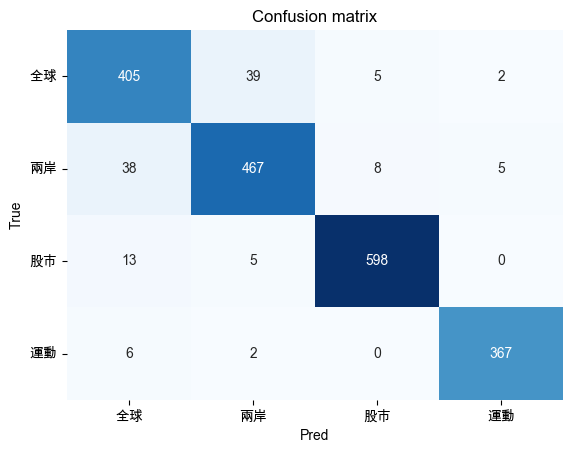

In [24]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

### 3.4 TF-IDF

改試試看使用 TF-IDF 的 DTM 來代表文章，訓練分類模型的效果

這邊使用到的TfidfVectorizer 和 上週使用到的TfidfTransformer都是用來計算文本的TF-IDF，不同的是TfidfTransformer適用於已經計算好詞頻的情況。

In [25]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vocabulary = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
tfidf_df

,一些,一位,一名,一場,一定,一家,一年,一度,一次,一直,...,高層,高度,高息,高於,高達,高階,高點,鼓勵,龍年,龍頭
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.062331,0.0,0.000000
1,0.000000,0.0,0.201985,0.0,0.0,0.0,0.389535,0.0,0.419387,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,0.041250,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.043114,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.096144,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.122937,0.0,0.000000
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4566,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
4567,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
4568,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.128645
4569,0.141912,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.197763,0.0,...,0.0,0.0,0.0,0.0,0.050914,0.0,0.0,0.000000,0.0,0.000000


In [26]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.90      0.93      0.91       451
          兩岸       0.93      0.92      0.93       518
          股市       0.98      0.97      0.97       616
          運動       0.99      0.98      0.98       375

    accuracy                           0.95      1960
   macro avg       0.95      0.95      0.95      1960
weighted avg       0.95      0.95      0.95      1960



效果一樣也是不錯，可能因為聯合新聞的四個新聞版別本來就有很大的差異，用字遣詞會不同。

### 3.5 CV

接著介紹 cross-validation。CV 在機器學習中，是一個很常用來讓模型評估能夠得到更穩定的數值的手法。

* figure1: 

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png"  width="1000">

* figure 2:  

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

source: <https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection>

cross-validation 會自動切成 k 組 train-test dataset。  
`cross_validate()` 會回傳經過 cross-validation 的模型評估結果。

In [27]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.07150102, 0.08251405, 0.06935692, 0.06552005, 0.07229495]),
 'score_time': array([0.00901198, 0.00915599, 0.00897503, 0.00956392, 0.00906515]),
 'test_f1_macro': array([0.94158432, 0.95042476, 0.93964961, 0.93657425, 0.94237814]),
 'test_precision_macro': array([0.94194512, 0.95065738, 0.94010582, 0.93696068, 0.94164803]),
 'test_recall_macro': array([0.94124692, 0.95023634, 0.93966483, 0.93639609, 0.94351359])}


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [47]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          全球       0.91      0.91      0.91      1163
          兩岸       0.91      0.92      0.91      1152
          股市       0.97      0.97      0.97      1345
          運動       0.98      0.98      0.98       911

    accuracy                           0.94      4571
   macro avg       0.94      0.94      0.94      4571
weighted avg       0.94      0.94      0.94      4571



## 4. 比較不同模型效果

In [29]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

          全球       0.91      0.91      0.91      1163
          兩岸       0.91      0.92      0.91      1152
          股市       0.97      0.97      0.97      1345
          運動       0.98      0.98      0.98       911

    accuracy                           0.94      4571
   macro avg       0.94      0.94      0.94      4571
weighted avg       0.94      0.94      0.94      4571



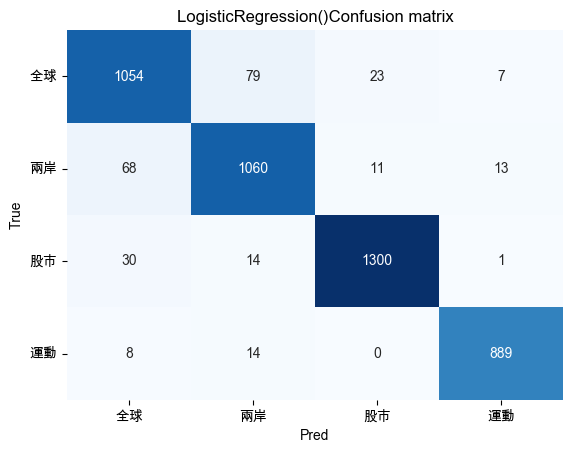

In [30]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

          全球       0.91      0.91      0.91      1163
          兩岸       0.91      0.92      0.91      1152
          股市       0.97      0.97      0.97      1345
          運動       0.98      0.98      0.98       911

    accuracy                           0.94      4571
   macro avg       0.94      0.94      0.94      4571
weighted avg       0.94      0.94      0.94      4571

now training: clf_dtree
              precision    recall  f1-score   support

          全球       0.75      0.74      0.75      1163
          兩岸       0.80      0.81      0.81      1152
          股市       0.90      0.90      0.90      1345
          運動       0.91      0.91      0.91       911

    accuracy                           0.84      4571
   macro avg       0.84      0.84      0.84      4571
weighted avg       0.84      0.84      0.84      4571

now training: clf_svm
              precision    recall  f1-score   support

  

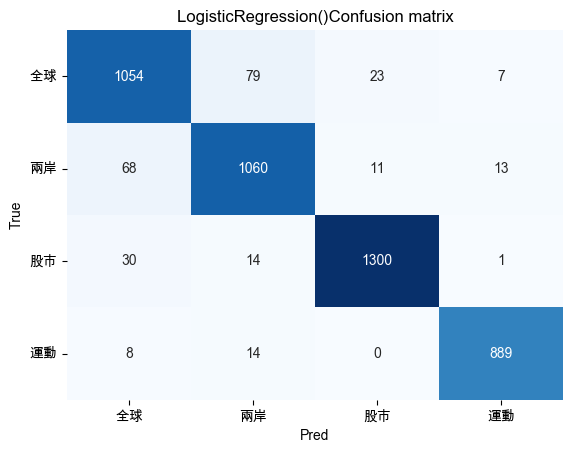

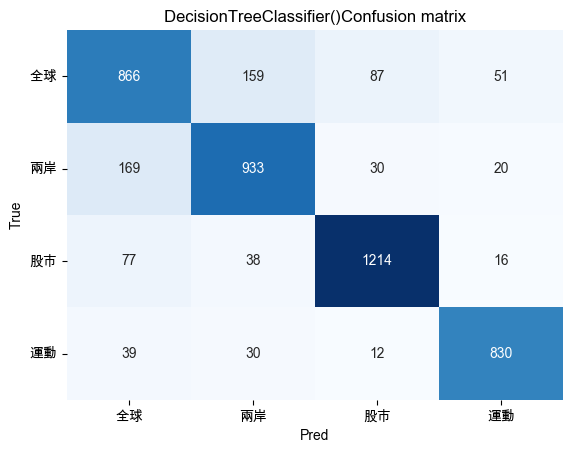

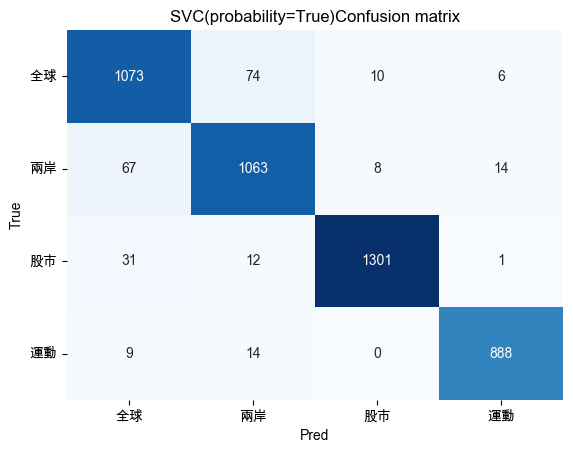

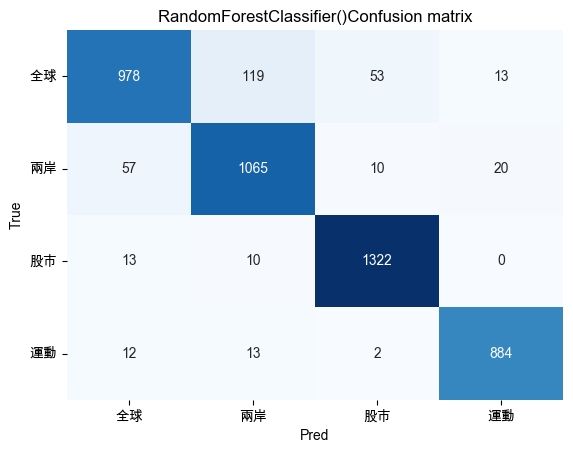

In [31]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


分別觀察各個分類模型在不同類別的評估指標表現如何

In [32]:
result_set['clf_logistic']

{'全球': {'precision': 0.9086206896551724,
  'recall': 0.9062768701633706,
  'f1-score': 0.907447266465777,
  'support': 1163.0},
 '兩岸': {'precision': 0.908311910882605,
  'recall': 0.9201388888888888,
  'f1-score': 0.9141871496334627,
  'support': 1152.0},
 '股市': {'precision': 0.974512743628186,
  'recall': 0.966542750929368,
  'f1-score': 0.9705113848450915,
  'support': 1345.0},
 '運動': {'precision': 0.9769230769230769,
  'recall': 0.9758507135016465,
  'f1-score': 0.9763866007688083,
  'support': 911.0},
 'accuracy': 0.9413695033909429,
 'macro avg': {'precision': 0.9420921052722601,
  'recall': 0.9422023058708184,
  'f1-score': 0.9421331004282848,
  'support': 4571.0},
 'weighted avg': {'precision': 0.9415440268349508,
  'recall': 0.9413695033909429,
  'f1-score': 0.9414418668113061,
  'support': 4571.0}}

+ 找出f1-score表現最好的模型是哪個，作為我們最終得到的分類器

In [33]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_svm
{'accuracy': 0.9461824546051192,
 'macro avg': {'f1-score': 0.9467072987146452,
               'precision': 0.9466471247085946,
               'recall': 0.9468490622655548,
               'support': 4571.0},
 'weighted avg': {'f1-score': 0.9463655615254013,
                  'precision': 0.9466388834611005,
                  'recall': 0.9461824546051192,
                  'support': 4571.0},
 '全球': {'f1-score': 0.9159197609901836,
        'precision': 0.9093220338983051,
        'recall': 0.9226139294926913,
        'support': 1163.0},
 '兩岸': {'f1-score': 0.9183585313174946,
        'precision': 0.9140154772141015,
        'recall': 0.9227430555555556,
        'support': 1152.0},
 '股市': {'f1-score': 0.9767267267267268,
        'precision': 0.9863532979529946,
        'recall': 0.9672862453531599,
        'support': 1345.0},
 '運動': {'f1-score': 0.9758241758241758,
        'precision': 0.976897689768977,
        'recall': 0.9747530186608123,
        'support': 911.0}}

In [34]:
y_pred = model_set['clf_svm'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          全球       0.90      0.94      0.92       451
          兩岸       0.93      0.93      0.93       518
          股市       0.99      0.97      0.98       616
          運動       0.99      0.97      0.98       375

    accuracy                           0.95      1960
   macro avg       0.95      0.95      0.95      1960
weighted avg       0.95      0.95      0.95      1960



In [35]:
model_set['clf_svm'].predict(vectorizer.transform(["菲律賓 大學 要求 帶防 作弊 憤怒 皮卡丘 同台 東森 新聞 菲律賓 一名 大學教授"]).toarray())

array(['全球'], dtype=object)

* 最佳的 model 為 SVM，其中 Decision Tree 的表現較差外，其餘三個 model （Logistic、SVM、Random Forest）表現差不多。
* 另外也可以嘗試用直接的詞頻表作為 `vectorizer`，比較看看相較 tfidf，是否效果更好。

## 5. 分析可解釋模型的結果

### 5.1 各字詞特徵的迴歸係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ 迴歸係數（coefficient estimates）反映了每個特徵對預測結果的影響程度和方向。​當其他變數保持不變時，某一特徵的值增加一個單位（例如詞頻增加1），其對應的迴歸係數表示該特徵對事件發生機率的影響。
+ 計算後得到勝算比（odds ratio），這表示該特徵每增加一個單位，事件發生的勝算（odds）相對於未增加時的倍數變化。
+ 這裡舉logistic regression + cv tokenizer 為例

In [36]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

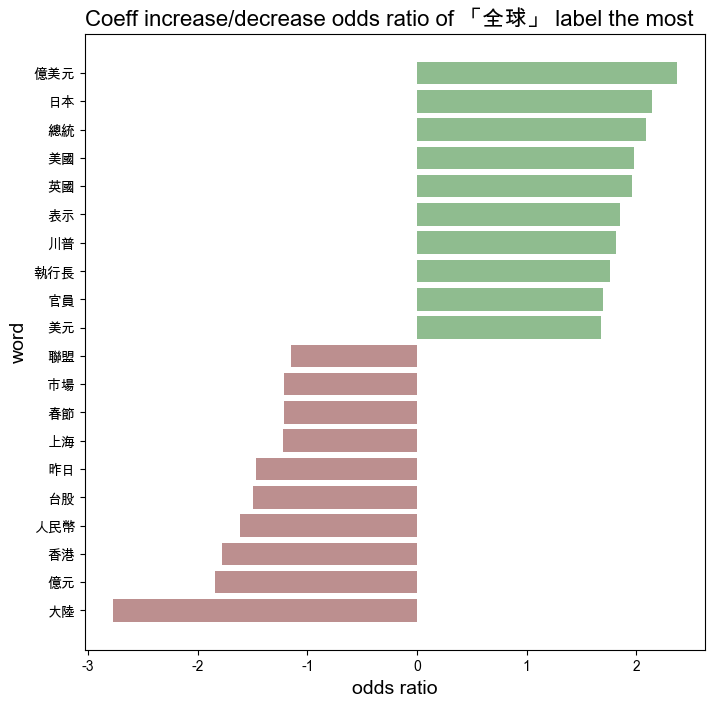

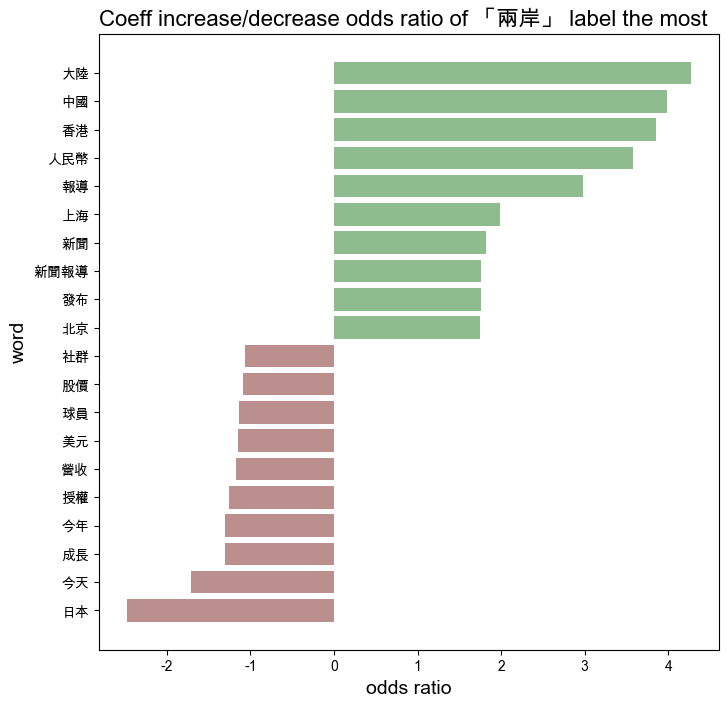

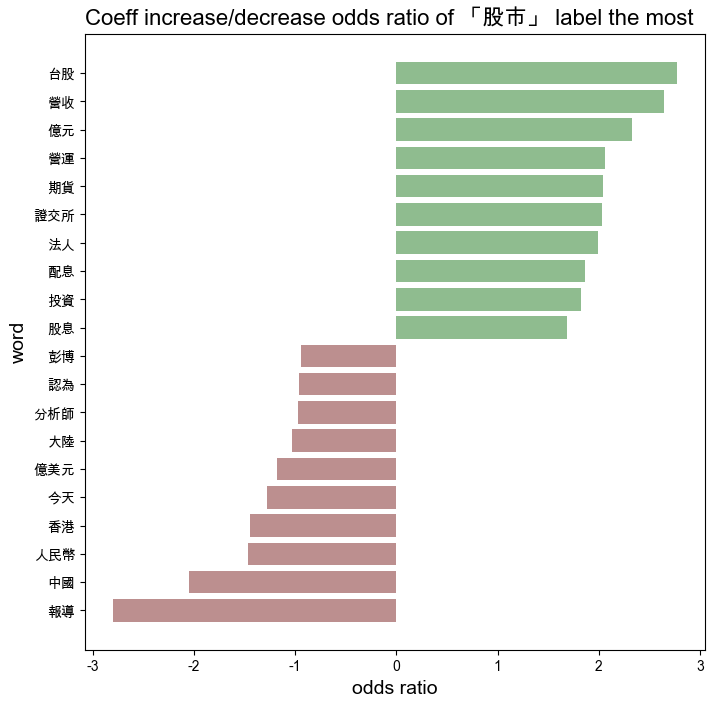

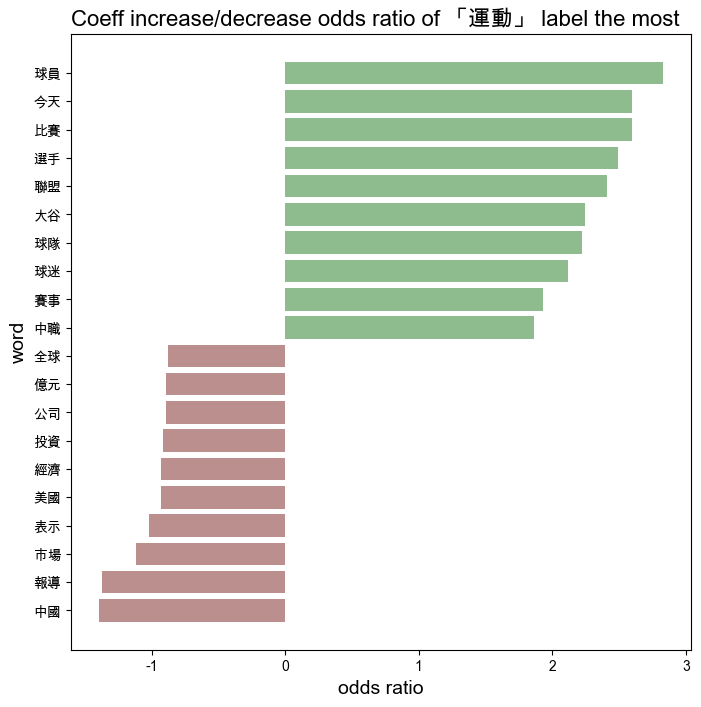

In [37]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

「全球」中出現了川普、美國、英國等國際新聞關鍵字；「兩岸」中高係數的字是與中國有關的大陸、中國、人民幣；「股市」則是台股、期貨相關的字；「運動」是比賽、球員、聯盟相關字。

## 6. 用訓練好的分類器來預測其他家的新聞類別

我們前面使用聯合新聞網的資料訓練好了分類器模型，接著用其他家新聞網的資料試試看分類的效果。

`ebc_news_202403.csv` 為東森新聞網資料
- 版別：財經、國際、體育、（政治、兩岸）
- 時間範圍：2024/03/01 ~ 2024/03/30
- 工作流程平台搜尋/排除關鍵字：無

In [38]:
ct = pd.read_csv("./raw_data/ebc_news_202403.csv")
ct.dropna(inplace=True)
ct

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,才喊話2年砍2萬人！花旗宣布「裁紐約286名員工」｜東森新聞,https://news.ebc.net.tw/news/article/407802,2024-03-01 13:40:00,財經,美國花旗集團日前才宣布，將在未來2年裁員2萬人，而根據該集團近日向美國勞工部（StateDe...,EBC
1,2,新／中鋼配0.35元 百萬股東哭了｜東森新聞,https://news.ebc.net.tw/news/article/407803,2024-03-01 12:41:00,財經,中鋼（2002）29日公布去年財報，112年度分配特別股股息每股現金1.4元及普通股紅利每股...,EBC
2,3,睡覺都有股票掉下來 達人曝挑個股2要件！｜東森新聞,https://news.ebc.net.tw/news/article/407835,2024-03-01 15:34:00,財經,投資人追求穩定的被動收入，不過，要是沒有足夠的本金，領到的股息也只能祭祭五臟廟；王仲麟認為，...,EBC
3,4,房市虛坪改革上膛！政院拋兩策略 喊公設可降10％｜東森新聞,https://news.ebc.net.tw/news/article/407854,2024-03-01 18:28:00,財經,內政部最新祭出「虛坪改革」兩大方案！將會從停車空間、管委會空間下手，舉個例子，如果改革方案上...,EBC
4,5,124萬股東哭哭！中鋼配息0.35元三年新低｜東森新聞,https://news.ebc.net.tw/news/article/407864,2024-03-01 19:52:00,財經,被外界號稱是被鋼鐵耽誤的紀念品公司中鋼，每年的股東會紀念品總是吸引大批股民搶購，甚至不少人存...,EBC
...,...,...,...,...,...,...,...
1177,1178,菲律賓大學要求帶防作弊帽 憤怒鳥、皮卡丘「罕同台」｜東森新聞,https://news.ebc.net.tw/news/article/412563,2024-03-29 21:43:00,國際,菲律賓一名大學教授曾為了防止學生考試作弊，要求他們戴上自製的「防作弊帽」，一時間成為網路熱門...,EBC
1178,1179,遊日韓注意！南韓空品嚴重惡化 沙塵暴將抵日｜東森新聞,https://news.ebc.net.tw/news/article/412567,2024-03-29 19:18:00,國際,趕著上班上課的民眾，出門在外總是口罩不離身，受到蒙古沙塵暴南下影響，南韓首爾周五上午天空霧茫...,EBC
1179,1180,哈利波特經典成真！麻瓜也能用「隱形斗篷」 只需台幣1.3萬｜東森新聞,https://news.ebc.net.tw/news/article/412591,2024-03-29 23:03:00,國際,英國新創團隊InvisibilityShieldCo.在2022年曾推出一款隱形盾牌，表面使...,EBC
1180,1181,哈瑪斯殺害德正妹「遊街羞辱」 美聯社獲年度照片惹議｜東森新聞,https://news.ebc.net.tw/news/article/412593,2024-03-29 22:53:00,國際,一名年僅30歲的德國籍以色列裔女性，原本在以色列參加音樂節，卻不幸遭到極端組織哈瑪斯（Ham...,EBC


In [39]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,才喊話2年砍2萬人！花旗宣布「裁紐約286名員工」｜東森新聞美國花旗集團日前才宣布，將在未來...,https://news.ebc.net.tw/news/article/407802,財經,喊話 萬人 花旗 宣布 紐約 286 員工 東森 新聞 美國花旗集團 日前 宣布 將在 未來...
1,新／中鋼配0.35元 百萬股東哭了｜東森新聞中鋼（2002）29日公布去年財報，112年度分...,https://news.ebc.net.tw/news/article/407803,財經,中鋼配 0.35 百萬 股東 東森 新聞 2002 29 公布 去年 財報 112 年度 分...
2,睡覺都有股票掉下來 達人曝挑個股2要件！｜東森新聞投資人追求穩定的被動收入，不過，要是沒有足...,https://news.ebc.net.tw/news/article/407835,財經,睡覺 股票 掉下來 達人 曝挑 個股 要件 東森 新聞 投資人 追求 穩定 被動 收入 足夠...
3,房市虛坪改革上膛！政院拋兩策略 喊公設可降10％｜東森新聞內政部最新祭出「虛坪改革」兩大方案...,https://news.ebc.net.tw/news/article/407854,財經,房市 虛坪 改革 上膛 政院 拋兩 策略 公設 可降 10 東森 新聞 內政部 最新 虛坪 ...
4,124萬股東哭哭！中鋼配息0.35元三年新低｜東森新聞被外界號稱是被鋼鐵耽誤的紀念品公司中鋼...,https://news.ebc.net.tw/news/article/407864,財經,124 股東 哭哭 中鋼 配息 0.35 三年 新低 東森 新聞 外界 號稱 鋼鐵 耽誤 紀...


觀察一下資料集的分佈狀況

In [40]:
ct['artCatagory'].value_counts()

artCatagory
國際    651
政治    262
財經    130
體育    126
兩岸     13
Name: count, dtype: int64

將東森的新聞類別給重新mapping到我們分類器的類別，接著開始進行分類任務

In [41]:
mapper = {"財經":"股市", "政治":"兩岸", "體育":"運動", "兩岸": "兩岸", "國際":"全球"}
ct['artCatagory'] = ct['artCatagory'].map(mapper)

X = ct['words']
y = ct['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          全球       0.66      0.65      0.65       651
          兩岸       0.27      0.34      0.30       275
          股市       0.97      0.53      0.69       130
          運動       0.91      0.94      0.93       126

    accuracy                           0.59      1182
   macro avg       0.70      0.61      0.64      1182
weighted avg       0.63      0.59      0.60      1182



從classification report可以發現，在東森新聞的資料集上，前面訓練得到的分類器在這邊表現並不好

接著進一步研究分類的結果，嘗試找出問題的原因

In [42]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,喊話 萬人 花旗 宣布 紐約 286 員工 東森 新聞 美國花旗集團 日前 宣布 將在 未來...,股市,全球
1,中鋼配 0.35 百萬 股東 東森 新聞 2002 29 公布 去年 財報 112 年度 分...,股市,股市
2,睡覺 股票 掉下來 達人 曝挑 個股 要件 東森 新聞 投資人 追求 穩定 被動 收入 足夠...,股市,股市
3,房市 虛坪 改革 上膛 政院 拋兩 策略 公設 可降 10 東森 新聞 內政部 最新 虛坪 ...,股市,股市
4,124 股東 哭哭 中鋼 配息 0.35 三年 新低 東森 新聞 外界 號稱 鋼鐵 耽誤 紀...,股市,股市
...,...,...,...
1177,菲律賓 大學 要求 帶防 作弊 憤怒 皮卡丘 同台 東森 新聞 菲律賓 一名 大學教授 防止...,全球,全球
1178,遊日韓 注意 南韓 空品 嚴重 惡化 沙塵暴 將抵 東森 新聞 趕著 上班 上課 民眾 出門...,全球,全球
1179,哈利波 經典 麻瓜 隱形 斗篷 需台幣 1.3 東森 新聞 英國 新創 團隊 Invisib...,全球,全球
1180,哈瑪斯 殺害 德正妹 遊街 羞辱 美聯社 年度 照片 惹議 東森 新聞 一名 年僅 30 德...,全球,全球


將錯誤分類的結果篩選出來

In [43]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
0,喊話 萬人 花旗 宣布 紐約 286 員工 東森 新聞 美國花旗集團 日前 宣布 將在 未來...,股市,全球
7,年金 改革 收入 公務員 退休 率降 36 東森 新聞 軍公教 人員 年金 改革 上路 退休...,股市,全球
9,印表機 大廠 全錄 啟動 裁員 員工 失業 東森 新聞 全球 知名 印表機 製造商 全錄 X...,股市,全球
11,比特 減半 倒數 睽違 重回 萬美元 東森 新聞 2024 比特 幣的 價格 現貨 ETF ...,股市,全球
12,夫妻 苦肉計 350 買房 半年 竟開 高價 轉賣 東森 新聞 買房 賣房 學問 日前 一名...,股市,兩岸
...,...,...,...
1163,經濟 感到 無力 中國 年輕人 上班 噁心 東森 新聞 中國 青年 未來 感到 無力 先前 ...,全球,兩岸
1166,河北 燕郊 大火 濃煙 直竄 電動車 起火 釀災 東森 新聞 中國 河北 燕郊 幾周 前才剛...,全球,兩岸
1168,黃金 央企 金店 陸民 損失 17 億台幣 東森 新聞 金價 創新 大陸 年輕人 已經 成為...,全球,兩岸
1173,健身 槓鈴 碰碎 手鐲 女客 求償 萬台幣 互告 東森 新聞 健身房 畫面 右方 黑衣 女子...,全球,兩岸


觀察看看全球類別的新聞，模型給出的分類結果怎麼樣

In [44]:
false_pred.loc[false_pred['artCatagory']=='全球', :].head(20)

,words,artCatagory,pred
531,重磅 公開 中國 天鷹 無人機 試飛 畫面 年首 曝光 東森 新聞 印太 地區 空軍 戰力 ...,全球,兩岸
534,中國 2024 兩會 需要 核酸 檢測 東森 新聞 中國 全國 兩會 政協 人大 拉開帷幕 ...,全球,兩岸
536,父母 離婚 聯繫 男童 無家可歸 留校 畫面 網友 東森 新聞 馬來西亞 日前 有張 令人 ...,全球,兩岸
538,27 男到 非洲 酋長 年薪 百萬 還能 東森 新聞 27 大陸 男子 李滿 2018 非洲...,全球,兩岸
539,裝窮 20 工作 還債 意外 繼承 億萬 家產 東森 新聞 中國 零食 巨頭 麻辣 王子 創...,全球,兩岸
542,赴陸 旅遊 期限 第一天 台灣 旅客 兩岸 來往 東森 新聞 中國 大陸 旅遊團 今天 限期...,全球,兩岸
545,世界 最潮 102 過世 全球 網友 IG 哀悼 東森 新聞 網友 封為 世界 最潮 時尚 ...,全球,兩岸
550,糊塗 大陸 蜘蛛人 忘帶 鑰匙 還爬 鄰居家 東森 新聞 微弱 燈光 勉強 清楚 警方 大聲...,全球,兩岸
554,雨傘 傘柄 神秘 貼紙 540 網友 東森 新聞 北台 近幾天 陰雨 綿綿 雨傘 成為 許多...,全球,兩岸
555,唱歌 突走音 就醫 查出 惡性腫瘤 東森 新聞 大陸 鄭州 女子 唱歌 突然 走音 檢查 惡...,全球,兩岸


挑選一篇全球類別的新聞文章觀察看看內容，為何模型會將其分類成兩岸的新聞

In [45]:
pprint(false_pred['words'][531])

('重磅 公開 中國 天鷹 無人機 試飛 畫面 年首 曝光 東森 新聞 印太 地區 空軍 戰力 發展 中國 重磅 公開 國產 無人機 天鷹 試飛 畫面 這款 '
 '戰機 長時間 巡航 飛行 隱形 具有 臨空 偵察 能力 設計師 直言 未來 發展 偵查 打擊 並用 戰機 型號 新加坡 則在 近期 宣布 增購 八架 '
 '35A 戰機 取代 現有 16 原有 12 35A 新加坡 空戰 陣容 堪稱 東南亞 跑道 滑行 起飛 外型 類似 美軍 轟炸機 歷經 研究 製造 中國 '
 '國產 無人 偵察機 天鷹 2017 11 首度 試飛 成功 足足 六年 中國 重磅 公開 當時 畫面 中國航天 科工 三院 洪忠 首飛 現在 印象 比較 '
 '天鷹 無人機 長時間 巡航 飛行 具有 臨空 偵察 能力 更能 實現 自主 起降 適合 高度 危險 戰場 執行 任務 載荷 能力 裝載 雷達 光電 電子 '
 '偵察 電子對抗 設備 設計師 表示 未來 天鷹 偵察 打擊 並用 有效 精準 打擊目標 整個 印太 地區 中國 積極 提升 軍事實力 面對 詭譎 南海 '
 '情勢 新加坡 政局穩定 人口 面積 近年 持續 武裝部隊 加強 部署 擁有 超音速 巡航 能力 全副武裝 起飛 全球 最強 戰機 35A 加入 新加坡 '
 '空軍 新加坡 國防部長 永宏 35A 設計 耐戰性 荷載 能力 更強 35 讚許 包括 短程 垂直 起降 35 機身 較大 續航力 作業 彈性 更高 '
 '新加坡 近期 宣布 將會 增購 35A 戰機 原本 新加坡 已經 訂購 12 35B 訂購 35A 將會 擁有 總共 20 具有 功能 第五代 戰機 '
 '取代 現有 16 戰機 陣容 堪稱 東南亞 最強 空軍 戰力 而身 全球 先進 35 比拼 對象 自然 中國 20 戰機 中國 20 飛行員 前方 15 '
 '公里 明白 急轉 急轉 20 35 屬於 等級 目前 全球 先進 第五代 戰機 202017 服役 已經 中國 五大 戰區 投入使用 中國 挑戰 35 '
 '35 測試 加速 推進 35 搭載 航母 福建 福建 全身 日前 首次 曝光 電磁 彈射 軌道 甲板 清楚 中國 第三艘 航母 福建 2022 六月 '
 '正式 下水 象徵 中國 海軍 邁進 一大步 特別 上面 使用 先進 電磁 

模型對另一個新聞網的預測結果比較普通。可以看到兩岸的 precision 與 recall 都相對低，從預測結果來看，可以發現東森新聞的「全球」類別，也常常會報導中國的資訊，因為出現中國、大陸等字樣，使模型預測成「兩岸」。

* accuracy可能會因為資料分布不同而有所偏差，所以評估模型的時候，可以加入一起 F1-score, recall, precision, AUC 等常見分類任務指標來評估。